In [444]:
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('gruvboxd')

In [111]:
#Importing useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from copy import deepcopy
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from warnings import filterwarnings
filterwarnings(action = 'ignore')
%matplotlib inline

In [473]:
raw = pd.read_csv('surveyofbodyfat.csv')
df = deepcopy(raw)

### Filtering: Correlation coefficient

In [474]:
#Features with above +-0.5 of correlation coefficient affect the most
df.corr()['BodyFat'].to_frame().sort_values(by='BodyFat', ascending=False).iloc[1:].T

,Abdomen,Chest,Hip,Weight,Thigh,Knee,Biceps,Neck,Forearm,Wrist,Age,Ankle,Height,Density
BodyFat,0.813432,0.70262,0.625201,0.612414,0.559608,0.508665,0.493271,0.490592,0.361387,0.346575,0.291458,0.26597,-0.089495,-0.987782


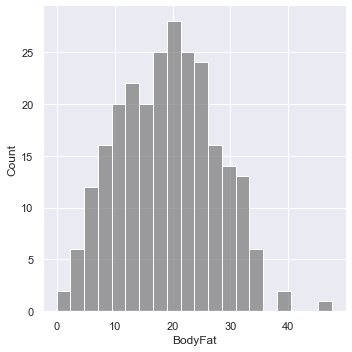

In [89]:
sns.displot(df['BodyFat'], bins=20, color='grey')
plt.show()

In [21]:
def normality_visual(data):
    for column in data.columns:
        fig = qqplot(data[column], line = '45', fit=True)
        ax = plt.gca() 
        fig.set_size_inches(15, 8) 
        ax.set_xlabel('Theoretical Quantiles', fontsize=13)
        ax.set_ylabel(f'Sample Quantiles of the {column} column', fontsize=13)
        plt.show()

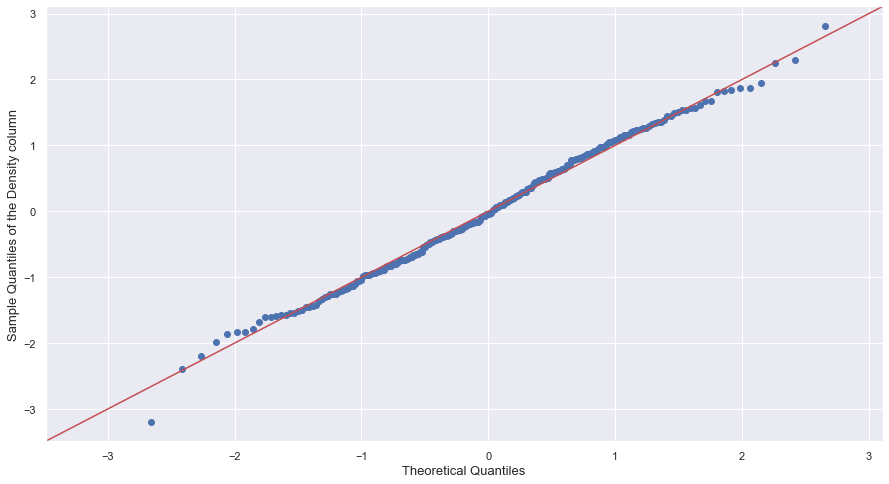

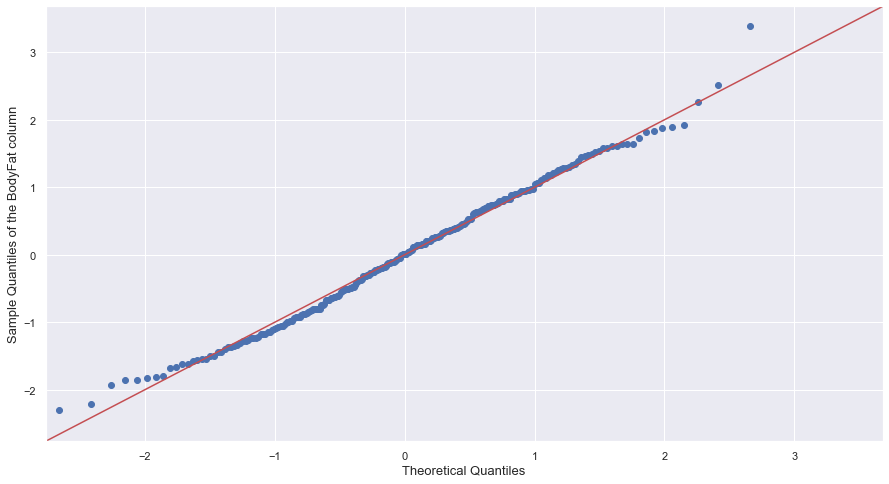

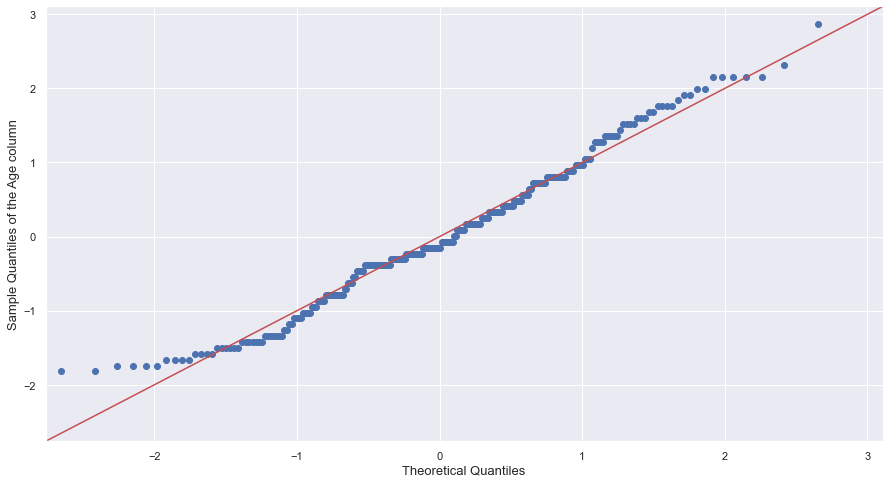

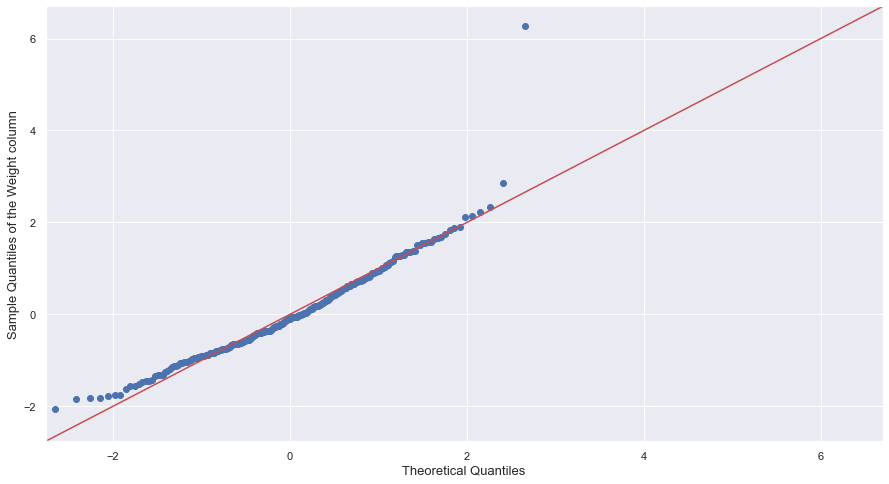

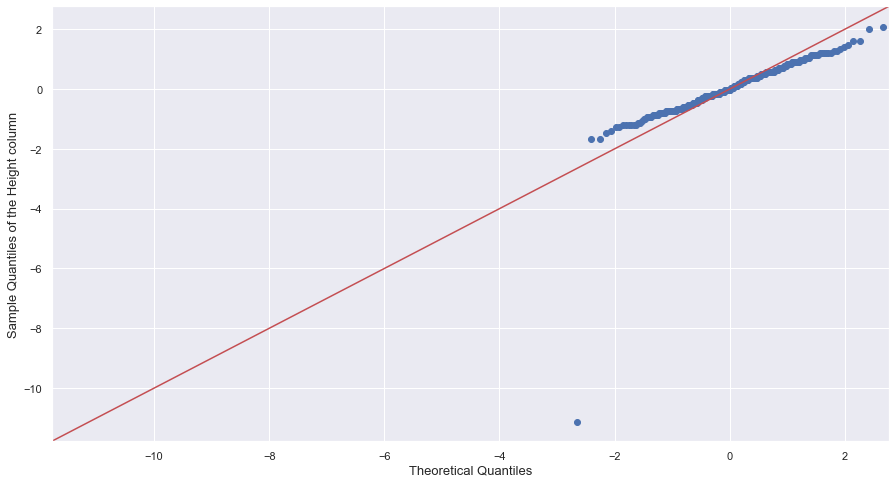

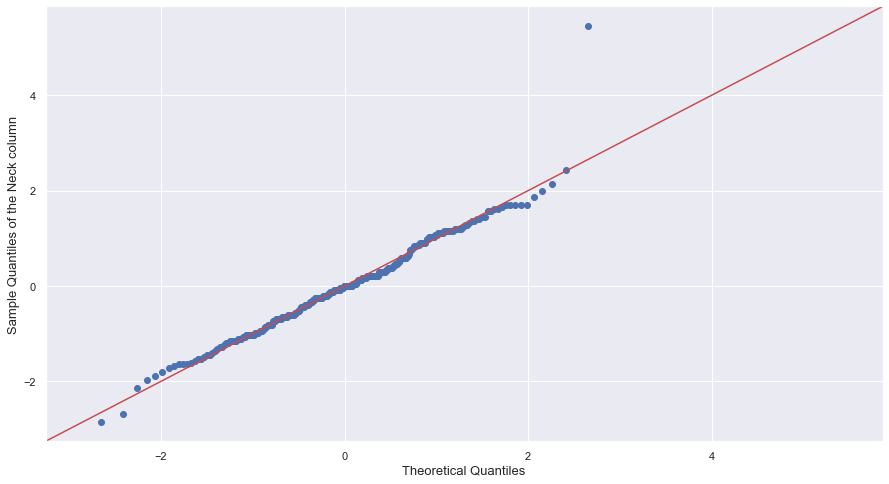

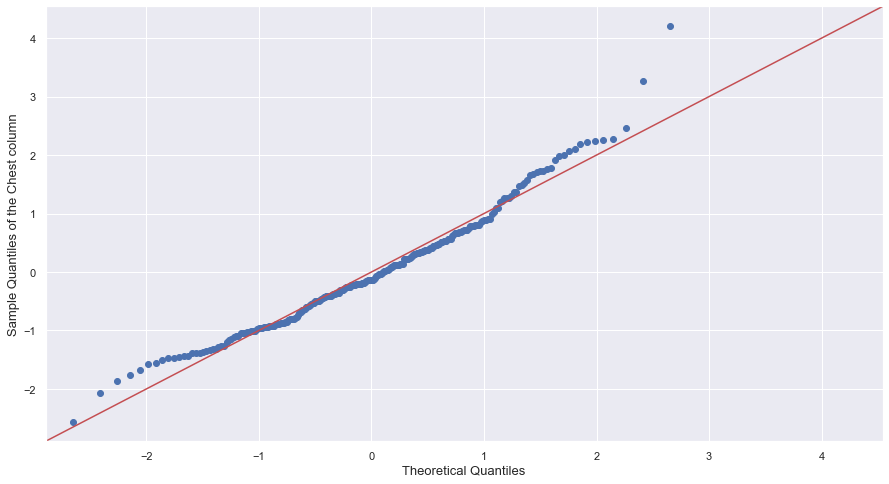

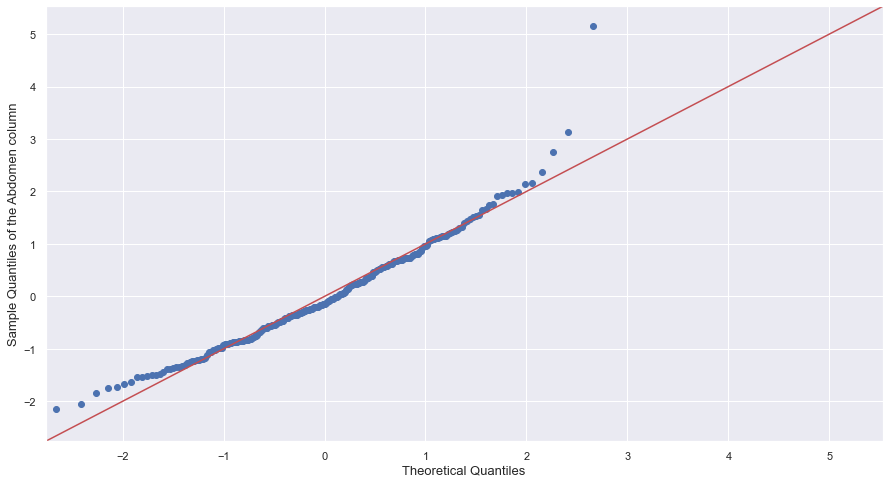

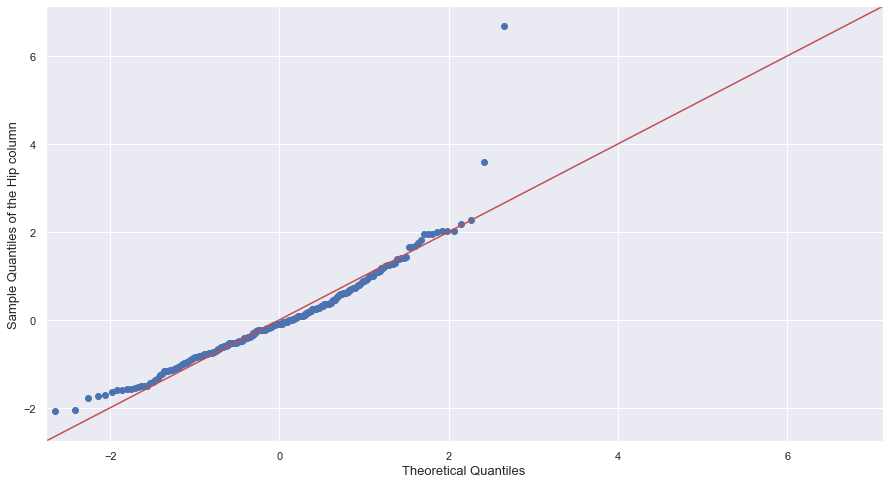

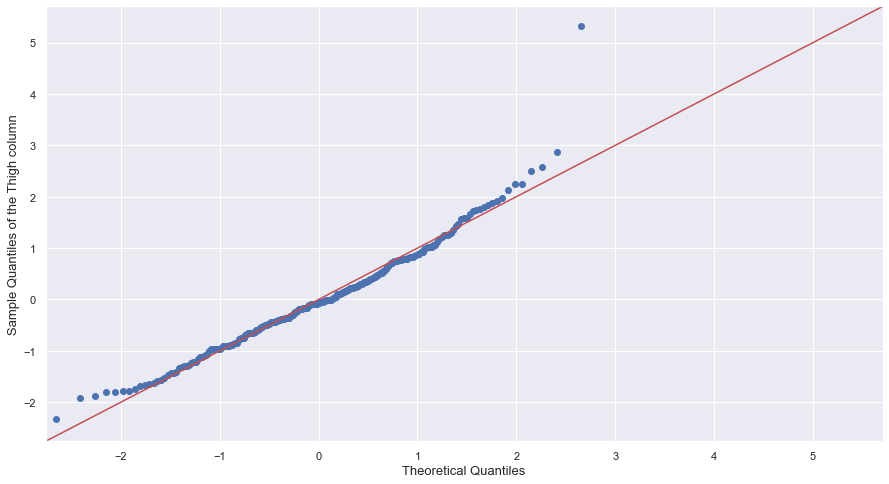

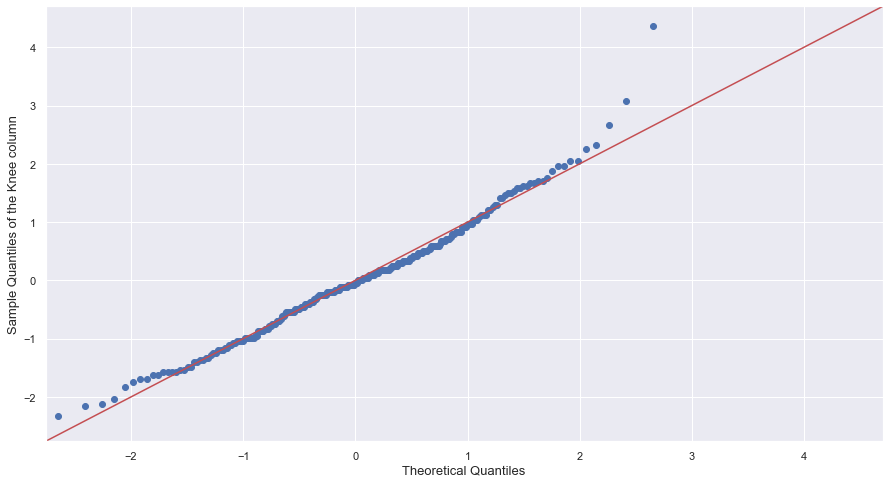

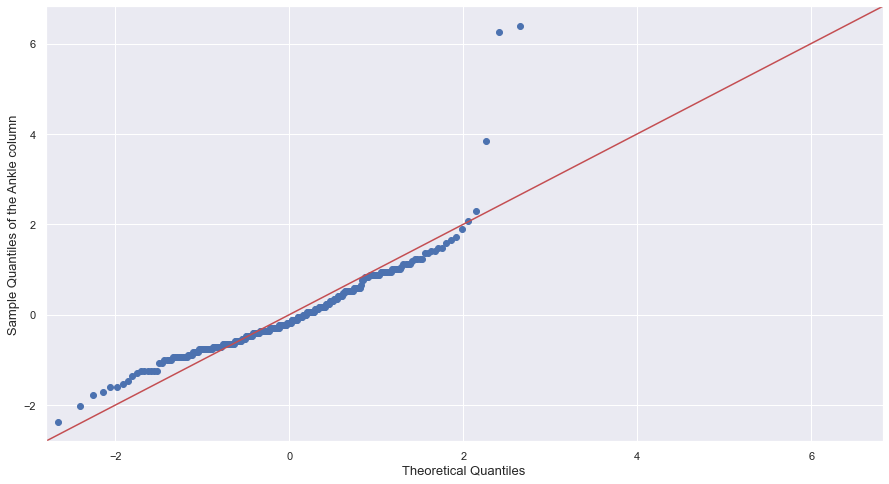

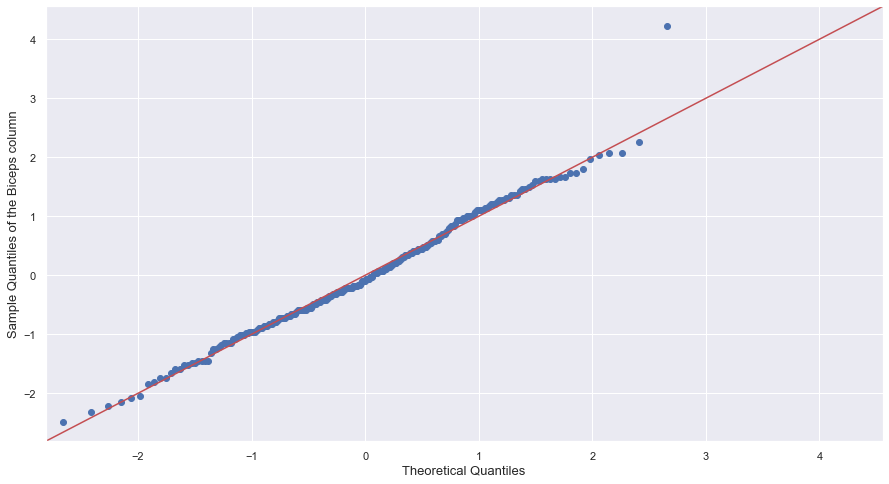

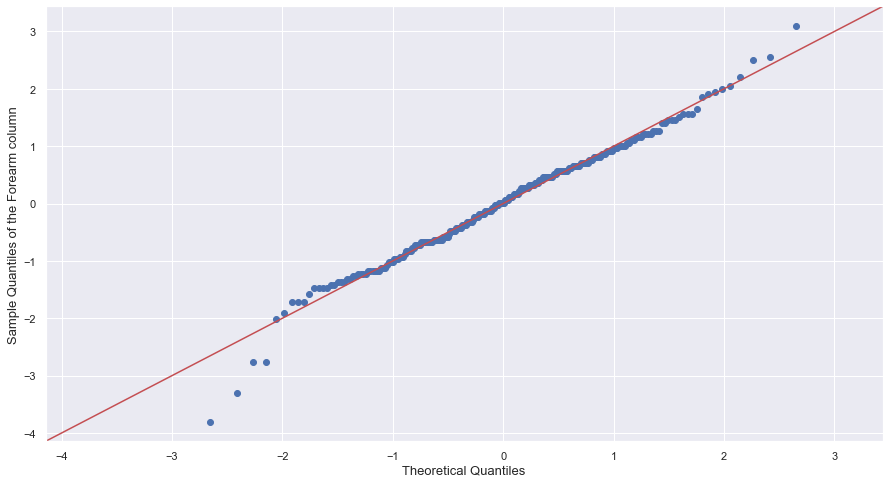

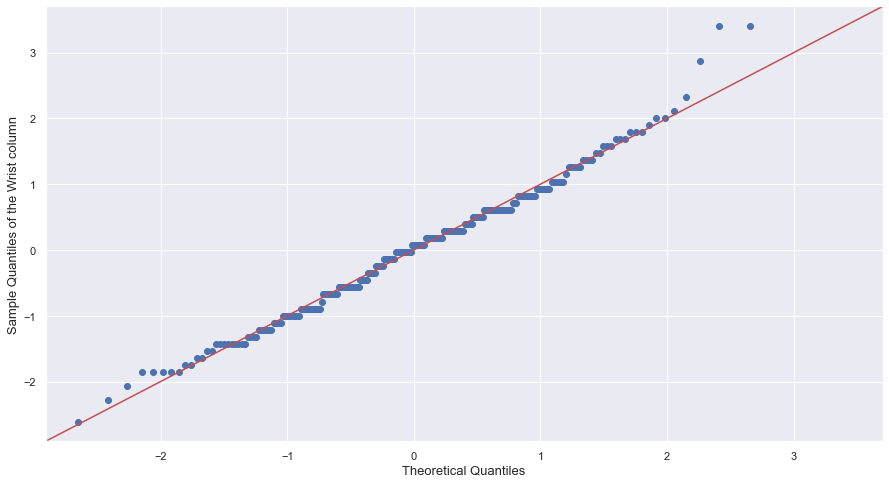

In [22]:
normality_visual(df)

#### The problem with dataset is that almost all features are correlated with one another which is natural because we're talking about bodily features. So if we were to build a model we'd have to apply conduct VIF to filter some columns.  

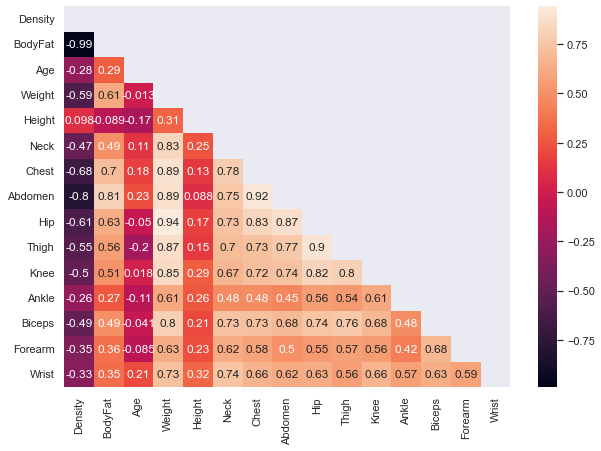

In [148]:
sns.set(rc={'figure.figsize':(10,7)})
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), mask=mask, annot=True)
plt.show()

### Filtering: Variance Inflation Factor (VIF)

In [475]:
df.describe().iloc[2,:].reset_index().T #standard deviations

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
index,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
std,0.019031,8.36874,12.60204,29.38916,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585


In [476]:
df.duplicated().sum()

0

In [477]:
def compute_vif(considered_features: list):  
    X = df[considered_features]
    X['intercept'] = 1
    
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [478]:
#Elimination
def drop_high_vif():
    vif_table = compute_vif([col for col in df.columns if col!='BodyFat']).sort_values(by='VIF', ascending=False).reset_index(drop=True) 
    
    while vif_table['VIF'].iloc[0]>5:
        df.drop(vif_table['Variable'][0], axis=1, inplace=True)
        vif_table = compute_vif([col for col in df.columns if col!='BodyFat']).sort_values(by='VIF', ascending=False).reset_index(drop=True) 
    
    return df.head()    

In [479]:
drop_high_vif()

,Density,BodyFat,Age,Height,Neck,Chest,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,67.75,36.2,93.1,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,72.25,38.5,93.6,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,66.25,34.0,95.8,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,72.25,37.4,101.8,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,71.25,34.4,97.3,42.2,24.0,32.2,27.7,17.7


In [480]:
df.corr()['BodyFat'].to_frame().sort_values(by='BodyFat', ascending=False).iloc[1:].T 

,Chest,Knee,Biceps,Neck,Forearm,Wrist,Age,Ankle,Height,Density
BodyFat,0.70262,0.508665,0.493271,0.490592,0.361387,0.346575,0.291458,0.26597,-0.089495,-0.987782


In [481]:
df = df[[f for f in df.columns if abs(df[f].corr(df['BodyFat']))>0.5]]

In [482]:
df = pd.concat([df.iloc[:,1:], df.iloc[:,0]], axis=1)

In [483]:
X = df.iloc[:,:-1]
y = df['BodyFat']

In [484]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [485]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train) 

scaler = RobustScaler()
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test)  

In [486]:
lin_mod = LinearRegression()
lin_mod.fit(X_train, y_train)
preds = lin_mod.predict(X_test)

In [487]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

2.141322817204513

In [488]:
r2_score(y_test, preds)

0.9156218786926885

In [489]:
mean_absolute_error(y_test, preds)

1.7606694677871215